<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

# **Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

### Instructor: Enrique Naredo
### ET5003_Etivity-1

In [1]:
#@title Current Date
Today = '2021-09-14' #@param {type:"date"}

In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20158327" #@param {type:"string"}
Student_full_name = "Xiaoming Zhang" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [6]:
# Setting a seed:
np.random.seed(100)

## Dataset

### Loading the MNIST dataset

### Note:
My test is running in local Juypter.<br>
Mnist test data path in my local is: ./mnist_data/

In [7]:
is_COLAB = 'google.colab' in str(get_ipython())
if is_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    Path = '/content/drive/MyDrive/Colab Notebooks/mnist/Data/'
else:
    Path = 'mnist_data/'

In [8]:
# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

(60000, 784)
(10000, 784)


In [9]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


### Description of Data:

In [10]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

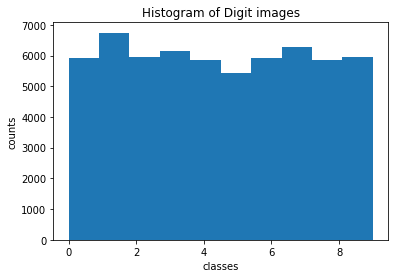

In [11]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

### Comments:
The train data is even distributed. Most of the numbers are around 6000 times

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [12]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
classes

[3, 7, 8]

In [13]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 1000

inputs = []
labels = []
# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

In [14]:
X_train.shape, y_train.shape

((3000, 784), (3000,))

New Classes Distribution

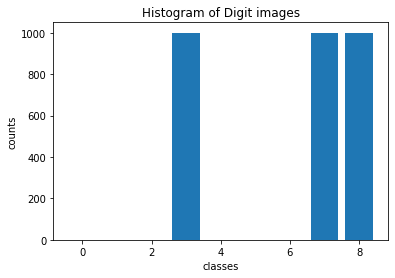

In [15]:
# new histogram
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, bins=range(10), align="left", rwidth=0.8)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

In [16]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

In [17]:
def random_labels(y_train, cnt=5):
    """
    random_labels: Randomly generate cnt lables for each digital number
    :param y_train: y_train (Array)
    :param cnt: The count of labels (int)
    :return: list[int]
    """
    labels = []
    class_cnt = len(set(y_train))
    len_y_train = len(y_train)
    width = int(len_y_train/class_cnt)
    for i in range(class_cnt):
        row = np.random.choice(width, cnt, replace=False) + i*width
        #print(row)
        labels.extend(row)
    return labels

Text(0.5, 1.0, 'Original')

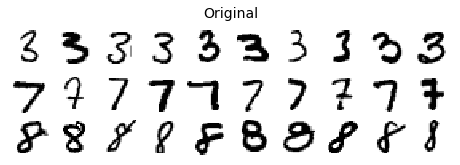

In [18]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices from each of the 3 classes to show:
# Randomly choose a few label indices. 10 labels for each Digit
label_indices = random_labels(y_train, cnt=10)

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=10)
plt.title("Original", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [19]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [20]:
# print shape of your validation and training set

print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_val Shape: {X_val.shape}')
print(f'y_val Shape: {y_val.shape}')

X_train Shape: (2400, 784)
y_train Shape: (2400,)
X_val Shape: (600, 784)
y_val Shape: (600,)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML

In [21]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)


# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
accuracy_score(y_pred_log, y_val)

0.9616666666666667

In [22]:
np.sort(prob_classmax)

array([0.55105937, 0.58706952, 0.61482748, 0.64130265, 0.65150755,
       0.71334551, 0.75165125, 0.77752602, 0.78000219, 0.80457218,
       0.85065103, 0.88736526, 0.90440242, 0.90972076, 0.91437944,
       0.93876412, 0.9396788 , 0.95068303, 0.95240734, 0.95749642,
       0.95950235, 0.96169225, 0.96196791, 0.96434085, 0.96623918,
       0.97159779, 0.97241535, 0.97355333, 0.97563012, 0.97610681,
       0.97663891, 0.97679795, 0.97757468, 0.98051568, 0.98068084,
       0.9819175 , 0.9846063 , 0.98507336, 0.98980397, 0.99044535,
       0.99162496, 0.99170046, 0.99204373, 0.99244889, 0.99267509,
       0.99302727, 0.99347011, 0.99383031, 0.99439994, 0.9944593 ,
       0.99448609, 0.99518273, 0.99542661, 0.99548108, 0.99563728,
       0.99577181, 0.99606641, 0.9968055 , 0.99704184, 0.99755325,
       0.99811918, 0.99812861, 0.99814208, 0.9983702 , 0.99838455,
       0.9983951 , 0.99854134, 0.9985593 , 0.99864967, 0.99873307,
       0.99880854, 0.99890244, 0.99905486, 0.99910984, 0.99914

In [23]:
# probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log!=y_val]

array([0.97663891, 0.65150755, 0.90972076, 0.95950235, 0.99244889,
       0.85065103, 0.75165125, 1.        , 0.95749642, 0.97679795,
       0.93876412, 0.99383031, 0.97355333, 0.99989755, 0.97159779,
       0.55105937, 0.80457218, 0.71334551, 0.97563012, 0.96434085,
       0.99890244, 0.98507336, 0.88736526])

In [24]:
np.array(y_pred_log)

array([3., 7., 7., 8., 8., 8., 8., 3., 7., 8., 7., 3., 3., 3., 7., 8., 7.,
       3., 3., 8., 8., 3., 7., 7., 8., 3., 7., 3., 7., 3., 8., 7., 8., 7.,
       7., 3., 3., 7., 8., 7., 7., 3., 3., 3., 3., 3., 8., 7., 8., 3., 7.,
       7., 3., 8., 3., 8., 8., 3., 8., 8., 8., 8., 8., 3., 8., 3., 7., 8.,
       3., 7., 7., 7., 7., 8., 7., 3., 3., 7., 7., 7., 7., 3., 3., 8., 3.,
       8., 3., 3., 7., 3., 7., 7., 3., 7., 3., 3., 7., 3., 3., 3., 8., 8.,
       3., 7., 3., 7., 7., 7., 3., 8., 7., 7., 7., 8., 7., 7., 8., 7., 7.,
       7., 8., 3., 8., 8., 3., 8., 7., 3., 8., 8., 7., 8., 8., 7., 3., 3.,
       8., 7., 8., 3., 8., 3., 8., 8., 3., 8., 7., 3., 7., 8., 3., 8., 8.,
       8., 3., 3., 7., 3., 3., 3., 7., 7., 3., 3., 7., 8., 7., 3., 7., 8.,
       3., 8., 8., 8., 7., 3., 7., 3., 8., 8., 3., 7., 8., 7., 8., 3., 7.,
       8., 8., 3., 8., 3., 3., 7., 7., 7., 3., 3., 3., 8., 3., 7., 3., 8.,
       7., 7., 8., 3., 8., 7., 7., 3., 7., 7., 8., 8., 3., 3., 3., 8., 3.,
       8., 8., 7., 8., 3.

### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [25]:
import sklearn.preprocessing
## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
nf = X_train.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

In [26]:
y_2_bin

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

In [27]:
%%time
with multi_logistic:
    #approx = pm.fit(300000, method='advi') # takes longer
    approx = pm.fit(3000, method='advi')

Finished [100%]: Average Loss = 9,433.6


CPU times: user 21.1 s, sys: 947 ms, total: 22.1 s
Wall time: 35 s


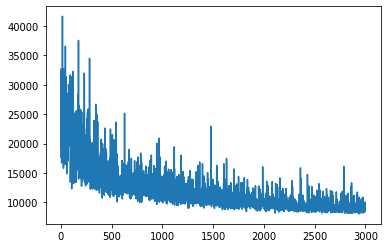

In [28]:
plt.plot(approx.hist)

In [29]:
dd = 300
posterior = approx.sample(draws=dd)

test image #10
posterior sample #100
true class= 7.0
classes: [3, 7, 8]
estimated prob= [0. 1. 0.]


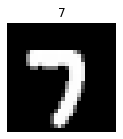

In [30]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
plt.title(int(y_val[i]))
plt.axis('off')
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

In [31]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [32]:
print(y_pred_Bayesian)

[0, 1, 1, 2, 2, 2, 2, 0, 1, 2, 1, 0, 0, 2, 1, 2, 1, 0, 2, 2, 2, 0, 1, 1, 2, 0, 1, 0, 1, 0, 2, 1, 2, 1, 1, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0, 1, 0, 1, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 1, 0, 2, 2, 1, 2, 2, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 2, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 2, 2, 1, 0, 1, 2, 0, 2, 2, 0, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 2, 0, 1, 2, 2, 0, 2, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 2, 2, 1, 2, 0, 2, 1, 1, 2, 1, 1, 2, 2, 0, 0, 0, 2, 0, 2, 2, 1, 2, 2, 1, 1, 0, 1, 2, 0, 0, 1, 1, 2, 2, 2, 1, 2, 1, 0, 0, 0, 0, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 2, 1, 0, 2, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 0, 2, 2, 0, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 0, 2, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 0, 0, 

In [33]:
# recall the classes we are using
print(classes)

[3, 7, 8]


In [34]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([3, 7, 7, 8, 8, 8, 8, 3, 7, 8])

In [35]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.91


### Selecting different instances

In [36]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [37]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.91134317, 0.29089899],
       [1.        , 0.99999397, 0.        ],
       [1.        , 0.98879094, 0.09949874],
       [2.        , 0.84344841, 0.35377331],
       [2.        , 0.86592326, 0.33993463],
       [2.        , 0.67731117, 0.45825757],
       [2.        , 0.5400944 , 0.49714742],
       [0.        , 0.96242247, 0.16110728],
       [1.        , 0.98971316, 0.08137704],
       [2.        , 0.96426736, 0.17950549]])

In [38]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[2.        , 0.49054639, 0.5       ],
       [0.        , 0.50133734, 0.49998889],
       [0.        , 0.50572215, 0.49998889],
       [2.        , 0.49207934, 0.49998889],
       [1.        , 0.5023346 , 0.49998889],
       [0.        , 0.48269145, 0.49998889],
       [2.        , 0.48588683, 0.49989999],
       [2.        , 0.48396561, 0.49982219],
       [0.        , 0.508613  , 0.49982219],
       [2.        , 0.50644149, 0.49972215]])

In [39]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log != y_val]

array([0.97663891, 0.65150755, 0.90972076, 0.95950235, 0.99244889,
       0.85065103, 0.75165125, 1.        , 0.95749642, 0.97679795,
       0.93876412, 0.99383031, 0.97355333, 0.99989755, 0.97159779,
       0.55105937, 0.80457218, 0.71334551, 0.97563012, 0.96434085,
       0.99890244, 0.98507336, 0.88736526])

In [40]:
y_predB[y_pred_log != y_val,:]

array([[2.        , 0.88939392, 0.3       ],
       [0.        , 0.66442573, 0.47140452],
       [1.        , 0.45071676, 0.49781746],
       [0.        , 0.65315559, 0.47590849],
       [2.        , 0.55815089, 0.49459299],
       [2.        , 0.95215521, 0.21092389],
       [0.        , 0.89103173, 0.29089899],
       [2.        , 0.84568401, 0.34698703],
       [2.        , 0.8281685 , 0.36660606],
       [2.        , 0.70154008, 0.4567883 ],
       [0.        , 0.78380373, 0.40491426],
       [2.        , 0.51158214, 0.49945526],
       [2.        , 0.97328923, 0.16110728],
       [0.        , 0.50572215, 0.49998889],
       [2.        , 0.66613748, 0.4689942 ],
       [0.        , 0.74154169, 0.41867516],
       [1.        , 0.99522643, 0.05763872],
       [1.        , 0.73411821, 0.43492017],
       [0.        , 0.45711054, 0.49811868],
       [2.        , 0.57945547, 0.49183331],
       [2.        , 0.47147171, 0.49945526],
       [0.        , 0.56331258, 0.49597267],
       [2.

In [41]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 0.99
Accuracy in difficult instances = 0.89


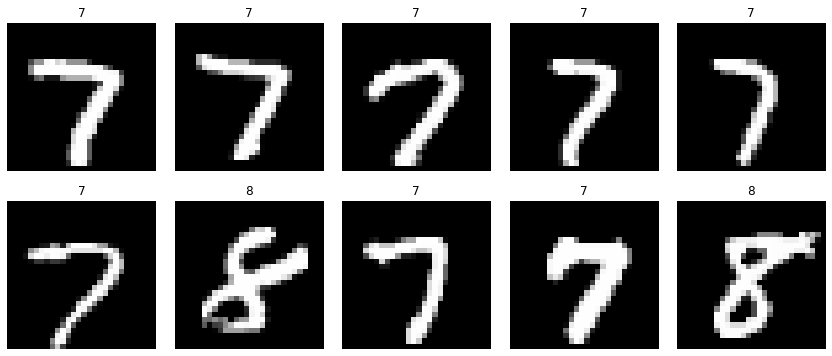

In [42]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    axs[i].set_title(int(y_val[index]))
    

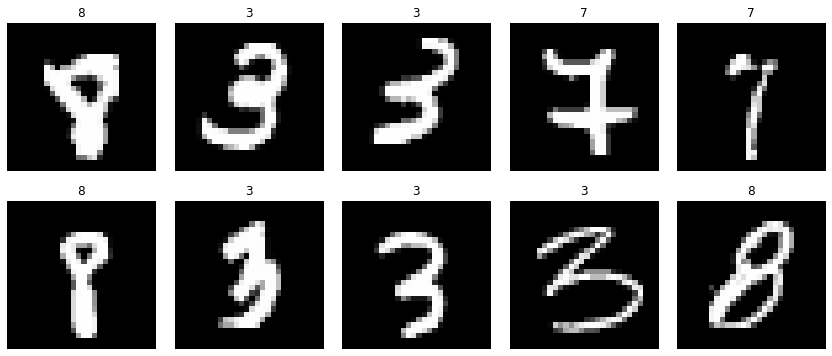

In [43]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    axs[i].set_title(int(y_val[index]))
    
    

## Summary

Populate this section with all of your findings and comments fron the discussion with your peers.